In [1]:
# Import required Libariers

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import data

df = pd.read_csv('data/employee.csv')

In [3]:
df.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain', 'LeaveOrNot'],
      dtype='object')

In [4]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [6]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


In [7]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

### EDA

In [8]:
df['LeaveOrNot'].value_counts()

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

In [9]:
df['PaymentTier'].value_counts()

PaymentTier
3    3492
2     918
1     243
Name: count, dtype: int64

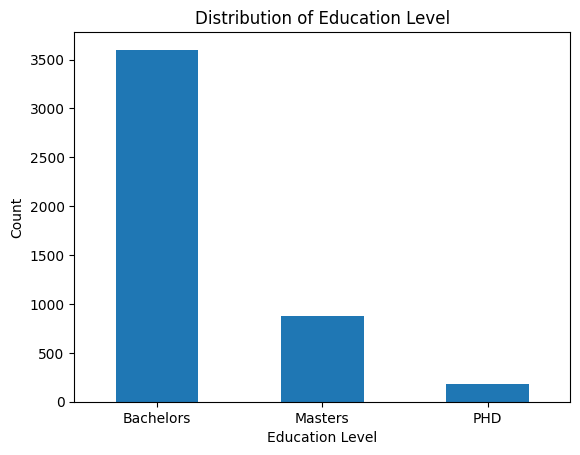

In [10]:
df['Education'].value_counts().plot(kind='bar')
plt.title('Distribution of Education Level')
plt.xlabel('Education Level')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

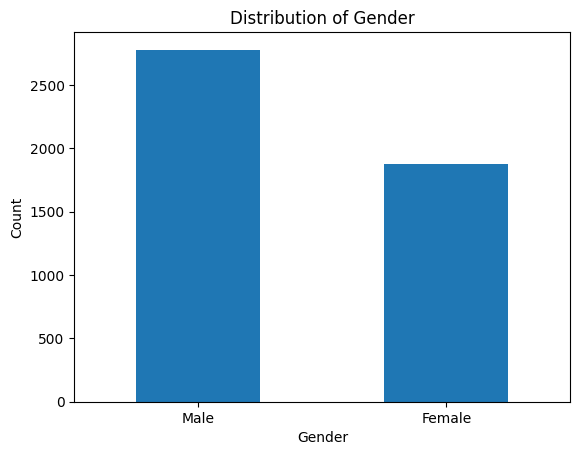

In [11]:
df['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

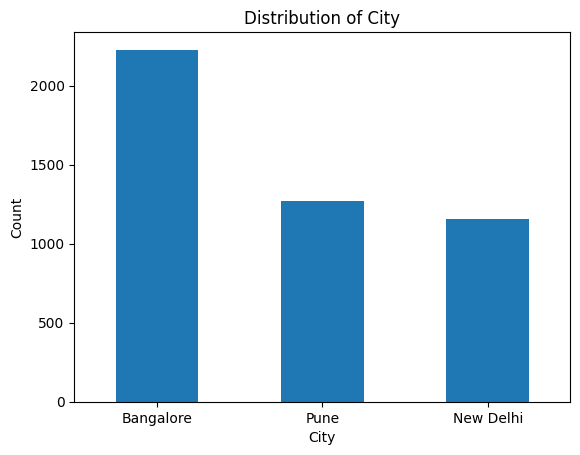

In [12]:
df['City'].value_counts().plot(kind='bar')
plt.title('Distribution of City')
plt.xlabel('City')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

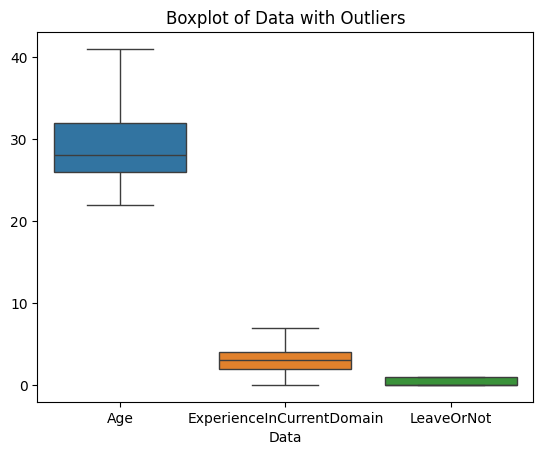

In [13]:
## Outliear Analysis

sns.boxplot(data=df.drop(['JoiningYear','PaymentTier'], axis=1))
plt.xlabel('Data')
plt.title('Boxplot of Data with Outliers')
plt.show()

In [14]:
X = df.drop('LeaveOrNot', axis=1)
y = df['LeaveOrNot']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [16]:
#MLflow 

import mlflow
from mlflow import MlflowClient

client = MlflowClient()

In [17]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [18]:
experiment_description = (
    "This is the employee retention project. "
)

experiment_tags = {
    "project_name": "employee-retention",
    "type": "classification",
    "mlflow.note.content": experiment_description,
}

# employee_experiment = client.create_experiment(name="Employee", tags=experiment_tags)

In [19]:
# Sets the current active experiment to the "Employee" experiment and returns the Experiment metadata
employee_experiment = mlflow.set_experiment("Employee")

In [20]:
import mlflow.sklearn

mlflow.sklearn.autolog()

2024/02/20 09:57:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Custom transformer for label encoding categorical features
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].dtype == 'object':
                self.label_encoders[column] = LabelEncoder().fit(X[column])
        return self

    def transform(self, X, y=None):
        X_encoded = X.copy()
        for column, encoder in self.label_encoders.items():
            if column in X.columns:
                X_encoded[column] = encoder.transform(X[column])
        return X_encoded


### Logistic Regression

In [22]:
lr = LogisticRegression()

lr_pipeline = Pipeline([
    ('label_encoder', LabelEncoderTransformer()),
    ('model', LogisticRegression())
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
mlflow.log_metrics({'accuracy_score': acc_lr})

2024/02/20 09:57:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ade76e1290fb4c5d9c968ca9c11fcd35', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/20 09:57:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\data\digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/02/20 09:58:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema

In [23]:
lr_pipeline

Pipeline(steps=[('label_encoder', LabelEncoderTransformer()),
                ('model', LogisticRegression())])

In [24]:
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("accuracy_score :",accuracy_score(y_test, y_pred_lr))

[[813 102]
 [289 192]]
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       915
           1       0.65      0.40      0.50       481

    accuracy                           0.72      1396
   macro avg       0.70      0.64      0.65      1396
weighted avg       0.71      0.72      0.70      1396

accuracy_score : 0.7199140401146131


### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('label_encoder', LabelEncoderTransformer()),
    ('model', RandomForestClassifier())
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
mlflow.log_metrics({'accuracy_score': acc_rf})

2024/02/20 09:58:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\data\digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."


2024/02/20 09:59:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/02/20 09:59:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\types\utils.py:393:

In [26]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("accuracy_score :", accuracy_score(y_test, y_pred_rf))

[[835  80]
 [135 346]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       915
           1       0.81      0.72      0.76       481

    accuracy                           0.85      1396
   macro avg       0.84      0.82      0.82      1396
weighted avg       0.84      0.85      0.84      1396

accuracy_score : 0.8459885386819485


In [27]:
rf_pipeline

Pipeline(steps=[('label_encoder', LabelEncoderTransformer()),
                ('model', RandomForestClassifier())])

### XGboost

In [32]:
from xgboost import XGBClassifier

xg_pipeline = Pipeline([
    ('label_encoder', LabelEncoderTransformer()),
    ('model', XGBClassifier())
])

xg_pipeline.fit(X_train, y_train)

y_pred_xg = xg_pipeline.predict(X_test)
acc_xg = accuracy_score(y_test, y_pred_xg)
mlflow.log_metrics({'accuracy_score': acc_xg})

2024/02/20 10:02:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\data\digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."


2024/02/20 10:03:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/02/20 10:03:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\employee\.venv\lib\site-packages\mlflow\types\utils.py:393:

In [29]:
print(confusion_matrix(y_test, y_pred_xg))
print(classification_report(y_test, y_pred_xg))
print("accuracy_score :",accuracy_score(y_test, y_pred_xg))

[[838  77]
 [134 347]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       915
           1       0.82      0.72      0.77       481

    accuracy                           0.85      1396
   macro avg       0.84      0.82      0.83      1396
weighted avg       0.85      0.85      0.85      1396

accuracy_score : 0.8488538681948424


In [30]:
xg_pipeline

Pipeline(steps=[('label_encoder', LabelEncoderTransformer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])